# STEP 2: Data Wrangling

## Project Overview: Objectives - Target vs. Features, General Plan

The primary/initial objective of this project is the binary classification of OCT image data into the target categories of either **"glaucoma"** or **"normal"** using a convolutional neural network (CNN).  As will be seen in more detail below, the first dataset contains exclusively 3D OCT Volumes centered on the optic nerve head (ONH), while the second one is a composite of fundus photography and 2D OCT B-scan images.  The hope is to obtain slices of the volumes in the first set and to crop down 2D b-scan images in the second set to potentially combine the sets and perform classification on 2D images only.  If this is not feasible or practical, then the focus will likely shift to classification of the volumes in the first set, replication of the CNN developed by the researchers that provided the dataset, and experimentation with alternative architectures.  However, this decision to keep or not keep Set 2 will likely be determined in later steps after this notebook, while this notebook will primarily be for consolidating of the different images, extraction of relevant tabular data pertaining to each image/volume file, organization and addition of additional labels, etc. for more systematic access of such image/volume data during later steps (EDA, Pre-processing, Modeling). 

# 0 | Import Statements

In [ ]:
import requests
import os, sys, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import magic
from zipfile import ZipFile
from datetime import datetime
import cv2

# 1 | Data Collection 

## 1.1 | Data Loading 

For this project, there are two key datasets with image data and class labels (Glaucoma vs. Normal), both of which are relatively large but can be downloaded via CLI.  Some helpful functions for more consistent downloading:

In [2]:
# Custom function for extracting zip file in more organized way
def unzip(zfpath,outpath):
    with ZipFile(zfpath,'r') as zipref:
        if not os.path.exists(outpath):
            os.mkdir(outpath)
        zipref.extractall(outpath)
        print(f'Contents of {os.path.basename(zfpath)} extracted to {outpath}')

# Function for downloading zip file from Zenodo and extracting into proper folder 
def download_datazip(url,dirname,parentDIR='../datasrc/',report_time=True):
    
    '''Downloads from provided link of a zip file, automatically extracting to 
    a specified folder name inside of the datasrc/ directory of this project.  
    If extraction is successful, the original zip file will be removed to save
    space / avoid redundancy.

    PARAMS
    ------
        url        :     Link to zip file.
        
        dirname    :     Name of directory to extract contents of zip file into
                         this will be located within `parentDIR`, which by default
                         is the `datasrc/` directory of the main project directory.
                         If path does not yet exist, it will be created.
        
        parentDIR  :     Path to directory where `dirname` is or will be created. 
                         By default, this is `../datasrc/`

        report_time:     If `True` (default), will print out the start and end times 
                         of the download, and report total time.
    '''
    
    targetPATH = os.path.join(parentDIR,dirname)
    zipfilePATH = targetPATH + '.zip'

    if report_time:
        # Start Time
        t_start = datetime.now()
        
    #-----------------#
    # Download zipfile
    print('Requesting data...')
    response = requests.get(url)
    filesize = sys.getsizeof(response.content)
    with open(zipfilePATH,'wb') as f:
        f.write(response.content)
    print(f'Downloaded zip file ({filesize:,.02f} bytes) to {zipfilePATH}')

    # Extract zip to target path
    try:
        unzip(zipfilePATH,targetPATH)
    except:
        raise NotImplementedError(f"Issue with either locating/creating {targetPATH},\
        extracting {zipfilePATH}, or removing {zipfilePATH} after extraction.")   
        
    # Remove zip file if successful
    os.remove(zipfilePATH)
    print(f'Removed {os.path.basename(zipfilePATH)} after extraction.')
    #-----------------#
    
    if report_time:
        # End Time
        t_end = datetime.now()
        # Time Report
        tdif = (t_end - t_start).total_seconds()
        if tdif > 3600:
            unit = 'hours'
            tdif = tdif / 3600
        elif tdif > 60 and tdif < 3600:
            unit = 'minutes'
            tdif = tdif / 60
        else:
            unit = 'seconds'
        print(f'Time Elapsed: {tdif:.4f} {unit}')

### SET 1: OCT Volumes (3D)

The data downloaded here are from the <i>[OCT volumes for glaucoma detection](https://zenodo.org/records/1481223)</i> dataset, published to **Zenodo** by Hiroshi Ishikawa from NYU, one of the authors of <i>[A feature agnostic approach for glaucoma detection in OCT volumes. (PLOS One, 2019)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126)</i>.  

NOTE: per the authors, the dataset only includes Optic Nerve Head (ONH) centered OCT Scans as 3D volumes in numpy format (`.npy` file extension).  The scans were originally 6 x 6 x 2 mm, corresponding to 200 x 200 x 1024 voxels, but were downsampled to 64 x 64 x 128 for the sake of computation.

#### <u>Downloading OCT Volumes</u>

In [3]:
# Establish paths/file structure names ahead of time for download 
# and potential reuse later - note: "v" prefix for "volumes"
vURL="https://zenodo.org/records/1481223/files/glaucoma_detection.zip?download=1"
vDIR = 'volumesOCT'
vPATH = os.path.join('../datasrc/',vDIR)

In [4]:
# Download OCT volumes using custom function
if not os.path.exists(vPATH):
    download_datazip(vURL,vDIR)


Requesting data...
Downloaded zip file (463,227,815.00 bytes) to ../datasrc/volumesOCT.zip
Contents of volumesOCT.zip extracted to ../datasrc/volumesOCT
Removed volumesOCT.zip after extraction.
Time Elapsed: 33.2823 seconds


### SET 2: Composite Fundus & OCT Images (2D)

These data come from [A Composite Retinal Fundus and OCT Dataset with Detailed Clinical Markings of Retinal Layers and Retinal Lesions to Grade Macular and Glaucomatous Disorders](https://data.mendeley.com/datasets/trghs22fpg/4), published by Taimur Hassan et al. (National University of Sciences and Technology, Khalifa University of Science and Technology) to **Mendeley**.  Note that this is the 4th version (most recent as of June 2025) published September 22, 2021, while the very first version was released Martch 18, 2021.  More information provided in the `README.md` of this project.

#### <u>Downloading Composite Fundus & OCT Images</u>

In [5]:
# Establish paths/file structure names ahead of time for download 
# and potential reuse later - note: "foc" prefix for "fundus-oct-composite"
focURL="https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/trghs22fpg-4.zip"
focDIRname = 'fundus-oct-composite'
foclongpath = '../datasrc/fundus-oct-composite/Dataset/Dataset/OD/'
focPATH = '/'.join(foclongpath.split('/')[:3])

In [6]:
# Download zip file for fundus-oct-composite (foc) dataset & extract
focURL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/trghs22fpg-4.zip"
download_datazip(focURL,'fundus-oct-composite')

# Inside the downloaded zip file is another zip file... so extract again
unzip('../datasrc/fundus-oct-composite/Dataset.zip','../datasrc/fundus-oct-composite/')
os.remove('../datasrc/fundus-oct-composite/Dataset.zip')

# Cut out redundant directory levels
foclongpath = '../datasrc/fundus-oct-composite/Dataset/Dataset/OD/'
focPATH = '/'.join(foclongpath.split('/')[:3])
for i in os.listdir(foclongpath):
    old = os.path.join(foclongpath,i)
    new = os.path.join(focPATH,i)
    os.rename(old,new)

# Discard irrelevant directories
shutil.rmtree(os.path.join(focPATH,'Dataset'))

# View contents
os.listdir('../datasrc/fundus-oct-composite/')

Requesting data...
Downloaded zip file (1,539,361,630.00 bytes) to ../datasrc/fundus-oct-composite.zip
Contents of fundus-oct-composite.zip extracted to ../datasrc/fundus-oct-composite
Removed fundus-oct-composite.zip after extraction.
Time Elapsed: 1.6262 minutes
Contents of Dataset.zip extracted to ../datasrc/fundus-oct-composite/


['Glaucoma', 'Healthy']

This dataset may distinguish labels by the parent folder, or perhaps both parent folder and filenames - will explore further to find out.

## 1.2 | Data Joining

As the data types between the two sets, along with directory structure differ, will save this step for after defining data types and potentially applying transformations to make them more compatible.

# 2 | Data Organization 

## 2.1 |  File Structure

### SET 1

<u> OCT Volumes File Structure </u>

For the OCT Volumes, the entirety of the dataset is a bunch of `.npy` files, containing the volume data for each OCT scan. 

In [7]:
os.listdir(vPATH)[:10]

['POAG-001978-2012-02-08-OS.npy',
 'Normal-002743-2009-03-26-OS.npy',
 'POAG-001086-2008-08-04-OS.npy',
 'POAG-000092-2010-12-14-OS.npy',
 'POAG-003223-2014-01-10-OD.npy',
 'POAG-002534-2008-10-21-OD.npy',
 'POAG-002853-2013-09-19-OD.npy',
 'POAG-002516-2016-09-01-OS.npy',
 'POAG-000695-2008-11-13-OS.npy',
 'Normal-002016-2010-03-25-OS.npy']

It appears any tabular data is encoded in the names of each file, such as the class label (Normal vs. POAG ,where POAG = Primary Open-Angle Glaucoma).

In [8]:
# Save list of volume file names to volNames for later use
volNames = os.listdir(vPATH)

### SET 2
<u> FOC Images (2D) File Structure </u>

As noted earlier, the fundus-oct-composite 2D image set seems to divide the data into separate file paths based on class label and potentially other features:

In [9]:
os.listdir(focPATH)

['Glaucoma', 'Healthy']

To explore the directory tree, will create function similar to the `tree` command in Bash.  

In [10]:
def tree(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * level
        print('{}{}/'.format(indent, os.path.basename(root)))
        for file in files:
            print('{}{}'.format(indent + ' ' * 4, file))

# tree(focPATH)

Will alternatively use `! tree <path>` as the package is installed locally:

In [11]:
! tree ../datasrc/fundus-oct-composite | head

../datasrc/fundus-oct-composite
├── Glaucoma
│   ├── P_1
│   │   └── Left Eye
│   │       ├── 2010154_20151020_093741_B-scan_L_001.jpg
│   │       ├── 2010154_20151020_093741_Color_L_001.jpg
│   │       ├── 2010154_20151020_093741_Red-free_L_001.jpg
│   │       ├── Fundus_Left_Glaucoma_Cup.jpg
│   │       ├── Fundus_Left_Glaucoma_Disc.jpg
│   │       ├── OCT_Left_Glaucoma_Cup.jpg


In [12]:
! tree -d --filelimit 10 ../datasrc/fundus-oct-composite

../datasrc/fundus-oct-composite
├── Glaucoma  [26 entries exceeds filelimit, not opening dir]
└── Healthy  [18 entries exceeds filelimit, not opening dir]

3 directories


In [13]:
! tree -d ../datasrc/fundus-oct-composite | head

../datasrc/fundus-oct-composite
├── Glaucoma
│   ├── P_1
│   │   └── Left Eye
│   ├── P_10
│   │   ├── Left Eye
│   │   └── Right Eye
│   ├── P_11
│   │   ├── Left Eye
│   │   └── Right Eye


Looks like many of the same potentially tabular features seen in the volume names are found partially in the file names here but also in the file paths / directory names, so this may take more work to parse out.

## 2.2 | GitHub Repository Information 

More information on the repository can be found at: [https://github.com/tbchuotmd/OCTCV](https://github.com/tbchuotmd/OCTCV)

# 3 | Data Definition

## 3.1 | Extraction of Tabular Data

As noted earlier, while both datasets are primarily image data, the file structure/naming encodes some potentially useful tabular information, at least from the perspective of organization & matching them to classification target labels.

### SET 1

In [14]:
# Display examples of filenames
volNames[64:66]

['Normal-003102-2009-09-03-OS.npy', 'POAG-000671-2009-07-30-OS.npy']

Based on the file naming convention seen above, we can establish column names based on what they represent, and then extract the values for each file into columns of a dataframe:

In [15]:
# Establish names for basic components to of the filename to split
vcols = "dx_class patient_id date laterality filename".split(' ')

# Initialize lists for each feature
dxs = []; pids = []; dates = []; lats = []

# Iterate through all filenames, extracting out the feature values and appending to lists
for name in volNames:   
    dx, pid, yr, mo, d, lat = name.strip('.npy').split('-')

    # combine the date elements (year,month,day) into a single datetime object
    dtstring = '-'.join([yr,mo,d])
    dt = datetime.strptime(dtstring,'%Y-%m-%d')
    
    dates.append(dt)
    dxs.append(dx)
    pids.append(pid)
    lats.append(lat)

# Combine resulting feature lists into a sample/data array, and transpose (for pandas format)
tbldata = np.array([ dxs, pids, dates, lats, volNames ]).T

# Convert to DataFrame
voluMetadata = pd.DataFrame(tbldata,columns=vcols)
voluMetadata.head()

,dx_class,patient_id,date,laterality,filename
0,POAG,001978,2012-02-08,OS,POAG-001978-2012-02-08-OS.npy
1,Normal,002743,2009-03-26,OS,Normal-002743-2009-03-26-OS.npy
2,POAG,001086,2008-08-04,OS,POAG-001086-2008-08-04-OS.npy
3,POAG,000092,2010-12-14,OS,POAG-000092-2010-12-14-OS.npy
4,POAG,003223,2014-01-10,OD,POAG-003223-2014-01-10-OD.npy


In [16]:
# Replace filename column with full filepath for convenience with accessing volumes
voluMetadata['filepath'] = voluMetadata.filename.apply(lambda filename: os.path.join(vPATH,filename))
voluMetadata = voluMetadata.drop('filename',axis=1)
voluMetadata.head()

,dx_class,patient_id,date,laterality,filepath
0,POAG,001978,2012-02-08,OS,../datasrc/volumesOCT/POAG-001978-2012-02-08-O...
1,Normal,002743,2009-03-26,OS,../datasrc/volumesOCT/Normal-002743-2009-03-26...
2,POAG,001086,2008-08-04,OS,../datasrc/volumesOCT/POAG-001086-2008-08-04-O...
3,POAG,000092,2010-12-14,OS,../datasrc/volumesOCT/POAG-000092-2010-12-14-O...
4,POAG,003223,2014-01-10,OD,../datasrc/volumesOCT/POAG-003223-2014-01-10-O...


### SET 2 

In [17]:
# For brevity, save the path to the fundus-oct-composite directory as focPATH
focPATH = '../datasrc/fundus-oct-composite/'
os.listdir(focPATH)

['Glaucoma', 'Healthy']

The 2D image dataset appears to have a more complicated file hierarchy, and the equivalent tabular information seem to be encoded in the full path rather than just file names.  Using the `glob` library, we can look for all paths (in this case all leading to files, which are hopefully all images):

In [18]:
# Within focPATH, get all paths that lead to *.* (i.e., assuming this would be a file)
filePaths = glob.glob(os.path.join(focPATH,'**','*.*'),recursive=True)

# Preview some of the file paths & check length
filePaths[:5], len(filePaths)

(['../datasrc/fundus-oct-composite/Glaucoma/P_26/Right Eye/99144_20140909_173003_Color_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right Eye/99144_20140909_173003_B-scan_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right Eye/99144_20140909_173003_Red-free_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left Eye/99144_20140909_173131_Red-free_L_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left Eye/99144_20140909_173131_Color_L_001.jpg'],
 419)

#### Cleaning File Paths

As spaces in file paths may become an issue down the line, will replace any of these with `_`:

In [19]:
def spaceReplacePathRenamer(file_path):
    '''Replaces all spaces in file paths with underscores, including parent and intermediate directories, 
    without moving the file itself.'''
    dir_path, file_name = os.path.split(file_path)
    if dir_path:
        new_dir_path = spaceReplacePathRenamer(dir_path) # Recursively rename paths one level at a time
        file_path = os.path.join(new_dir_path, file_name) # Update file_path with new dir path

    newFilePath = file_path  # initialize newFilePath

    if ' ' in file_name:
        new_file_name = file_name.replace(' ', '_')
        newFilePath = os.path.join(os.path.dirname(file_path), new_file_name)

        if os.path.exists(file_path):
            os.rename(file_path, newFilePath)
        else:
            # print(f"File path {file_path} does not exist, skipping rename")
            pass

    return newFilePath

In [20]:
# Rename spaces in all of the file paths
renamedFilePaths = [ spaceReplacePathRenamer(fp) for fp in filePaths ]

# Check if the renaming was successful (renamed file paths should be different now, len should be the same)
renamedFilePaths == filePaths, len(renamedFilePaths), np.array([os.path.exists(fp) for fp in renamedFilePaths]).sum()


(False, 419, 419)

In [21]:
# Check if the renaming was successful before reassigning it the the original filePaths variable
if len(renamedFilePaths) == np.array([os.path.exists(fp) for fp in renamedFilePaths]).sum():
    filePaths = renamedFilePaths
else:
    raise Exception('Renaming failed')

In [22]:
# Preview some of the file paths & check length
filePaths[:5], len(filePaths)

(['../datasrc/fundus-oct-composite/Glaucoma/P_26/Right_Eye/99144_20140909_173003_Color_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right_Eye/99144_20140909_173003_B-scan_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right_Eye/99144_20140909_173003_Red-free_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left_Eye/99144_20140909_173131_Red-free_L_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left_Eye/99144_20140909_173131_Color_L_001.jpg'],
 419)

#### Ensuring Consistent File Types

These all look like `.jpg` image files, but to be sure, let's apply `magic.from_file()` method to check the MIME-types:

In [23]:
# Ensure all of these files are are images
imgPaths = [ fp for fp in filePaths if magic.from_file(fp,mime=True).startswith('image') ]

# Preview a few image paths and check length
imgPaths[0:5], len(imgPaths)

(['../datasrc/fundus-oct-composite/Glaucoma/P_26/Right_Eye/99144_20140909_173003_Color_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right_Eye/99144_20140909_173003_B-scan_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Right_Eye/99144_20140909_173003_Red-free_R_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left_Eye/99144_20140909_173131_Red-free_L_001.jpg',
  '../datasrc/fundus-oct-composite/Glaucoma/P_26/Left_Eye/99144_20140909_173131_Color_L_001.jpg'],
 417)

Looks like two files that were not images were filtered out (down to 417 from 419).

In [24]:
# Get paths that are not images
nonImages = [ fp for fp in filePaths if fp not in imgPaths ]; nonImages

['../datasrc/fundus-oct-composite/Healthy/P_12/Right_Eye/2d_rt.wmv',
 '../datasrc/fundus-oct-composite/Healthy/P_12/Left_Eye/2d_lt.wmv']

While not images, they do seem to be video files - due there only being 2 files, it may be best to drop these altogether, although may consider some visualization / exploration in the EDA step to see if frames can potentially be combined to reconstruct a volume.  For now, will only consider 2D images.

#### Checking for Missing Data / Inconsistent Path Lengths

In [25]:
# Check if all paths descend an equal number of levels
list(set([ len(ip.split('/')) for ip in imgPaths ]))

[7]

All paths descend 7 levels, so this can make for a consistent number of columns based on `/`  as the delimiter.  But the first few levels are notably just `focPATH`, so we can cut that out for the sake of leaving only parts to be extracted as tabular data:

In [26]:
# Cut out the first part (../datasrc/fundus-oct-composite/) of the path
subpaths = [ ip.split(focPATH)[-1] for ip in imgPaths ]

# Print length and preview a few paths in the middle of the list:
midIdx = int(len(subpaths)/2)
print(len(subpaths))
print(subpaths[midIdx:midIdx+10])

417
['Glaucoma/P_3/Right_Eye/Fundus_Right_Glaucoma_Disc.jpg', 'Glaucoma/P_3/Right_Eye/109159_20150910_095053_B-scan_R_001.jpg', 'Glaucoma/P_3/Right_Eye/OCT_Right_Glaucoma_Disc.jpg', 'Glaucoma/P_3/Left_Eye/109159_20150910_095213_B-scan_L_001.jpg', 'Glaucoma/P_3/Left_Eye/109159_20150910_095213_Red-free_L_001.jpg', 'Glaucoma/P_3/Left_Eye/Fundus_Left_Glaucoma_Cup.jpg', 'Glaucoma/P_3/Left_Eye/109159_20150910_095213_Color_L_001.jpg', 'Glaucoma/P_3/Left_Eye/OCT_Left_Glaucoma_Disc.jpg', 'Glaucoma/P_3/Left_Eye/Fundus_Left_Glaucoma_Disc.jpg', 'Glaucoma/P_3/Left_Eye/OCT_Left_Glaucoma_Cup.jpg']


In [27]:
# Initialize DataFrame with both `subpaths` and the full paths (`imgPaths`)
imgMetadata = pd.DataFrame({'subpath':subpaths,'filepath':imgPaths})

# Establish the '/'-delimited column names nested within the filepaths
imfields = "dx_class patient_id laterality filename".split(' ')

# Split subpath into the imfields columns & drop the subpath column from the df.
imgMetadata[imfields] = imgMetadata.subpath.str.strip('/').str.split('/', expand=True)
imgMetadata.drop(columns=['subpath'])

# Rearrange column order so that filepath (lengthy values) are last. 
imgMetadata = imgMetadata[imfields+['filepath']]

imgMetadata.head(50).tail(10)

,dx_class,patient_id,laterality,filename,filepath
40,Glaucoma,P_1,Left_Eye,OCT_Left_Glaucoma_Disc.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_1/L...
41,Glaucoma,P_1,Left_Eye,2010154_20151020_093741_Color_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_1/L...
42,Glaucoma,P_1,Left_Eye,Fundus_Left_Glaucoma_Disc.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_1/L...
43,Glaucoma,P_1,Left_Eye,OCT_Left_Glaucoma_Cup.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_1/L...
44,Glaucoma,P_1,Left_Eye,2010154_20151020_093741_Red-free_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_1/L...
45,Glaucoma,P_24,Right_Eye,0808145_20140808_120742_B-scan_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_24/...
46,Glaucoma,P_24,Right_Eye,0808145_20140808_120742_Red-free_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_24/...
47,Glaucoma,P_24,Right_Eye,0808145_20140808_120742_Color_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_24/...
48,Glaucoma,P_24,Left_Eye,0808145_20140808_121150_Red-free_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_24/...
49,Glaucoma,P_24,Left_Eye,0808145_20140808_121150_Color_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_24/...


Each filename seems to contain some of the metadata already extracted from the file paths in addition to some substrings that indicate specific types and subtypes of images (Fundus, OCT, B-scan, Cup vs. Disc, etc.), which may better be represented as its own column.

#### Creating additional categories via image names 

In [28]:
# REGEX replacements to filter out the file extensions, 
# the lengthy string of numerical digits at the start,
# any string of numberical digits at the end,
# and categorical features already extracted (Left,Right,Glaucoma,Normal)
imgMetadata['image_type'] = imgMetadata.filename\
    .str.replace(r'\.[A-Za-z]+$','',regex=True)\
    .str.replace(r'^([0-9]+_){3}','',regex=True)\
    .str.replace(r'_[0-9]+.*$','',regex=True)\
    .str.replace(r'_[L,N,G,R][a-z]*','',regex=True)

# Rearrange columns for readability
imgMetadata = imgMetadata["dx_class patient_id laterality image_type filename filepath".split(' ')]
imgMetadata.head()

,dx_class,patient_id,laterality,image_type,filename,filepath
0,Glaucoma,P_26,Right_Eye,Color,99144_20140909_173003_Color_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
1,Glaucoma,P_26,Right_Eye,B-scan,99144_20140909_173003_B-scan_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
2,Glaucoma,P_26,Right_Eye,Red-free,99144_20140909_173003_Red-free_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
3,Glaucoma,P_26,Left_Eye,Red-free,99144_20140909_173131_Red-free_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
4,Glaucoma,P_26,Left_Eye,Color,99144_20140909_173131_Color_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...


In [29]:
# view unique types
imageTypes = [ t for t in imgMetadata.image_type.unique() if type(t)==str ]
imageTypes

['Color',
 'B-scan',
 'Red-free',
 'Fundus_Cup',
 'OCT_Cup',
 'Fundus_Disc',
 'OCT_Disc',
 'OCT_ME_Cyst']

## 3.2 | Column Names & Descriptions

#### SET 1

In [30]:
for col in voluMetadata.columns:
    print(col)

dx_class
patient_id
date
laterality
filepath


|Column| Description |
|:-----------|:-------|
| dx_class   | binary categorical class label (either glaucoma or normal/healthy) |
| patient_id        | patient identification # |
| laterality | right eye (OD) or left eye (OS) |
| filepath   | path to `.npy` file containing 3D volume array (can be read into memory using `numpy.load()`) |

#### SET 2

In [31]:
for col in imgMetadata.columns:
    print(col)

dx_class
patient_id
laterality
image_type
filename
filepath


| Column     | Description                                                                                               |
|:-----------|:----------------------------------------------------------------------------------------------------------|
| dx_class   | binary categorical class label (`Glaucoma`, `Healthy`)                                                                                   |
| patient_id        | patient identification # (e.g., `P_26`)                                                                                            |
| laterality | right eye or left eye (`Left_Eye`, `Right_Eye`)                                                                                 |
| study_type | type of study (`Fundus`, `OCT`)                                                                                         |
| image_type | type of image for given study (e.g., `Red-free` is a type of `Fundus` image)                                                                                        |
| filepath   | (e.g., `../datasrc/fundus-oct-composite/Glaucoma/P_26/Left_Eye/99144_20140909_173131_Red-free_L_001.jpg`) |

## 3.3 | Data Types

#### Tabular Data Types

In [32]:
voluMetadata.dtypes

dx_class              object
patient_id            object
date          datetime64[ns]
laterality            object
filepath              object
dtype: object

In [33]:
imgMetadata.dtypes

dx_class      object
patient_id    object
laterality    object
image_type    object
filename      object
filepath      object
dtype: object

Since all of the tabular data were extracted from filepaths and/or filenames, all of features will be of the `object` data type aside from the `date` column in `voluMetadata` since that was intentionally converted to a `datetime`.  Given the features are all categorical, this should be appropriate for now, while transformations such as one-hot encoding can be further considered during pre-processing.

#### Reformatting categorical data within the two sets to match where applicable 




##### *Making `dx_class` either `glaucoma` or `normal`*

In [34]:
voluMetadata['dx_class'] = voluMetadata.dx_class.str.lower().apply(lambda x : "glaucoma" if x == "poag" else x)

voluMetadata.dx_class.unique()

array(['glaucoma', 'normal'], dtype=object)

In [35]:
imgMetadata['dx_class'] = imgMetadata.dx_class.str.lower().apply(lambda x : "normal" if x == "healthy" else x)

imgMetadata.dx_class.unique()

array(['glaucoma', 'normal'], dtype=object)

##### *Making `laterality` either `OD` (Right) or `OS` (Left)*

In [36]:
voluMetadata.laterality.unique()

array(['OS', 'OD'], dtype=object)

In [37]:
imgMetadata['laterality'] = imgMetadata.laterality\
    .str.lower()\
    .apply(lambda x : "OD" if x.startswith('right') else "OS")

imgMetadata.laterality.unique()

array(['OD', 'OS'], dtype=object)

#### Ensuring Consistent Image Study Types (Dropping Fundus Images from Dataframe)

Since we are interested in OCT scans, it will be useful to isolate them from the fundus images.  As the substrings referring to image types don't always specify "OCT" or "Fundus", will visualize sample images of each type to get an idea:

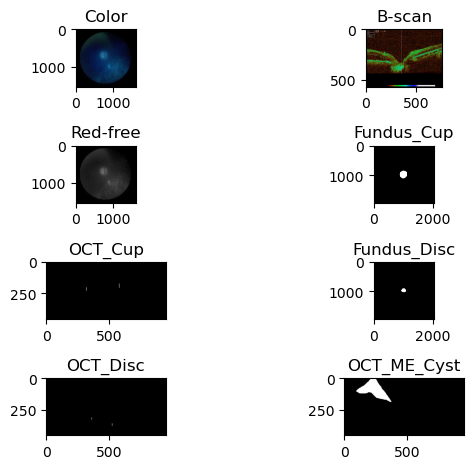

In [38]:
getSampleImgPath = lambda imgType : list(imgMetadata[imgMetadata['image_type'] == imgType]['filepath'])[0]

sampleImgPaths = { imgType:getSampleImgPath(imgType) for imgType in imageTypes }
ncols = 2
nrows = len(sampleImgPaths) // ncols

_,ax = plt.subplots(nrows,ncols)

for i,(imgType, imgPath) in enumerate(sampleImgPaths.items()):
    imgarr = cv2.imread(imgPath)
    ax.flat[i].set_title(imgType)
    ax.flat[i].imshow(imgarr)

plt.tight_layout()
    

So it looks like B-scan & OCT pertain to actual OCT scans, although only the images that have "B-scan" in their name are actual images of the retina, while the others are masks/labels of sub-regions.  Can probably drop the "OCT_ME_Cysts" since they represent something outside of the region of interest.  Otherwise, anything with "Fundus" in it seems to be masks/labels for fundus photographs, while the "Red-free" and "Color" images variations of actual fundus photographs.

In [39]:
# Drop ME cyst
imgMetadata = imgMetadata[~imgMetadata['image_type'].str.lower().str.contains('cyst')]
imgMetadata.shape

(416, 6)

In [40]:
# Create study_type column based on image_type content
imgMetadata['study_type'] = imgMetadata.image_type\
    .apply(lambda x : "OCT" if\
           'oct' in str(x).lower()\
           or 'b-scan' in str(x).lower()\
           else "Fundus")

imgMetadata = imgMetadata["dx_class patient_id laterality study_type image_type filename filepath".split(' ')]

imgMetadata.head()

,dx_class,patient_id,laterality,study_type,image_type,filename,filepath
0,glaucoma,P_26,OD,Fundus,Color,99144_20140909_173003_Color_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
1,glaucoma,P_26,OD,OCT,B-scan,99144_20140909_173003_B-scan_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
2,glaucoma,P_26,OD,Fundus,Red-free,99144_20140909_173003_Red-free_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
3,glaucoma,P_26,OS,Fundus,Red-free,99144_20140909_173131_Red-free_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
4,glaucoma,P_26,OS,Fundus,Color,99144_20140909_173131_Color_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...


In [41]:
# Remove 'OCT_' from image_type now that study_type has been extracted into its own column
imgMetadata['image_type'] = imgMetadata['image_type'].str.replace('OCT_','')
imgMetadata.head()

,dx_class,patient_id,laterality,study_type,image_type,filename,filepath
0,glaucoma,P_26,OD,Fundus,Color,99144_20140909_173003_Color_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
1,glaucoma,P_26,OD,OCT,B-scan,99144_20140909_173003_B-scan_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
2,glaucoma,P_26,OD,Fundus,Red-free,99144_20140909_173003_Red-free_R_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
3,glaucoma,P_26,OS,Fundus,Red-free,99144_20140909_173131_Red-free_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
4,glaucoma,P_26,OS,Fundus,Color,99144_20140909_173131_Color_L_001.jpg,../datasrc/fundus-oct-composite/Glaucoma/P_26/...


In [42]:
# Drop filename column now that relevant information has been extracted from it
imgMetadata = imgMetadata.drop('filename',axis=1)
imgMetadata.head()

,dx_class,patient_id,laterality,study_type,image_type,filepath
0,glaucoma,P_26,OD,Fundus,Color,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
1,glaucoma,P_26,OD,OCT,B-scan,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
2,glaucoma,P_26,OD,Fundus,Red-free,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
3,glaucoma,P_26,OS,Fundus,Red-free,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
4,glaucoma,P_26,OS,Fundus,Color,../datasrc/fundus-oct-composite/Glaucoma/P_26/...


In [43]:
# Make image_type column lowercase
imgMetadata['image_type'] = imgMetadata['image_type'].str.lower()

# Rearrange columns for readability
imgMetadata = imgMetadata["dx_class patient_id laterality study_type image_type filepath".split(' ')]
imgMetadata.head()

,dx_class,patient_id,laterality,study_type,image_type,filepath
0,glaucoma,P_26,OD,Fundus,color,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
1,glaucoma,P_26,OD,OCT,b-scan,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
2,glaucoma,P_26,OD,Fundus,red-free,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
3,glaucoma,P_26,OS,Fundus,red-free,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
4,glaucoma,P_26,OS,Fundus,color,../datasrc/fundus-oct-composite/Glaucoma/P_26/...


In [44]:
# Get subset of imgMetadata where study_type is 'OCT'
bscanMetadata = imgMetadata[imgMetadata['study_type'] == 'OCT'].drop(['study_type'],axis=1)
print(bscanMetadata.shape)
bscanMetadata.head()

(170, 5)


,dx_class,patient_id,laterality,image_type,filepath
1,glaucoma,P_26,OD,b-scan,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
5,glaucoma,P_26,OS,b-scan,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
6,glaucoma,P_16,OS,b-scan,../datasrc/fundus-oct-composite/Glaucoma/P_16/...
11,glaucoma,P_6,OD,b-scan,../datasrc/fundus-oct-composite/Glaucoma/P_6/R...
12,glaucoma,P_6,OD,cup,../datasrc/fundus-oct-composite/Glaucoma/P_6/R...


In [45]:
# Add in null dates to match voluMetadata
bscanMetadata['date'] = np.nan

# Rearrange columns
bscanMetadata = bscanMetadata["dx_class patient_id laterality image_type date filepath".split(' ')]
bscanMetadata.head()

,dx_class,patient_id,laterality,image_type,date,filepath
1,glaucoma,P_26,OD,b-scan,NaN,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
5,glaucoma,P_26,OS,b-scan,NaN,../datasrc/fundus-oct-composite/Glaucoma/P_26/...
6,glaucoma,P_16,OS,b-scan,NaN,../datasrc/fundus-oct-composite/Glaucoma/P_16/...
11,glaucoma,P_6,OD,b-scan,NaN,../datasrc/fundus-oct-composite/Glaucoma/P_6/R...
12,glaucoma,P_6,OD,cup,NaN,../datasrc/fundus-oct-composite/Glaucoma/P_6/R...


In [46]:
# Add image_type column to voluMetadata
voluMetadata['image_type'] = 'volume'

# Rearrange columns
voluMetadata = voluMetadata["dx_class patient_id laterality image_type date filepath".split(' ')]

# Preview voluMetadata for comparison
voluMetadata.head() 

,dx_class,patient_id,laterality,image_type,date,filepath
0,glaucoma,001978,OS,volume,2012-02-08,../datasrc/volumesOCT/POAG-001978-2012-02-08-O...
1,normal,002743,OS,volume,2009-03-26,../datasrc/volumesOCT/Normal-002743-2009-03-26...
2,glaucoma,001086,OS,volume,2008-08-04,../datasrc/volumesOCT/POAG-001086-2008-08-04-O...
3,glaucoma,000092,OS,volume,2010-12-14,../datasrc/volumesOCT/POAG-000092-2010-12-14-O...
4,glaucoma,003223,OD,volume,2014-01-10,../datasrc/volumesOCT/POAG-003223-2014-01-10-O...


## 3.4 | Counts, Percentages, & Ranges

### SET 1: Counts & Ranges of Metadata for 3D OCT Volumes

In [47]:
voluMetadata.describe()

,date
count,1110
mean,2010-08-10 15:49:37.297297152
min,2007-10-19 00:00:00
25%,2008-11-26 12:00:00
50%,2009-11-09 12:00:00
75%,2011-11-19 12:00:00
max,2016-11-30 00:00:00


Patient data ranges from 2007-10-19 to 2016-11-30

In [48]:
# See what years are most common
voluMetadata['date'].dt.year.value_counts()

date
2008    287
2009    270
2010    159
2011     96
2013     88
2012     85
2014     58
2016     41
2007     26
Name: count, dtype: int64

Majority of data are from 2008 to 2010.

In [49]:
# Check class distribution
voluMetadata['dx_class'].value_counts()

dx_class
glaucoma    847
normal      263
Name: count, dtype: int64

Not particularly balanced, although in theory POAG should be rare compared to Normal in a general population.

In [50]:
# Check laterality distribution
voluMetadata['laterality'].value_counts()

laterality
OD    559
OS    551
Name: count, dtype: int64

Very balanced, likely indicates majority of patients had OD/OS pairs.

In [51]:
N_pts_with_TWOscans = (voluMetadata.value_counts('patient_id') == 2).sum(); N_pts_with_TWOscans

486

In [52]:
N_pts_with_ONEscan = (voluMetadata.value_counts('patient_id') == 1).sum(); N_pts_with_ONEscan

138

In [53]:
N_patients = len(voluMetadata['patient_id'].unique())

N_patients, N_patients == N_pts_with_ONEscan + N_pts_with_TWOscans

(624, True)

For patients with two scans, do we know for sure they are one of each eye vs. two of the same eye?

In [54]:
twoScanPIDs = ((voluMetadata['patient_id'].value_counts() == 2)==True).index

scanCounts = voluMetadata['patient_id'].value_counts()

dualScanPIDs = scanCounts[scanCounts == 2].index



dualScans = voluMetadata[voluMetadata['patient_id'].isin(dualScanPIDs)]

print(dualScans.shape)
dualScans.head() 


(972, 6)


,dx_class,patient_id,laterality,image_type,date,filepath
1,normal,002743,OS,volume,2009-03-26,../datasrc/volumesOCT/Normal-002743-2009-03-26...
2,glaucoma,001086,OS,volume,2008-08-04,../datasrc/volumesOCT/POAG-001086-2008-08-04-O...
3,glaucoma,000092,OS,volume,2010-12-14,../datasrc/volumesOCT/POAG-000092-2010-12-14-O...
4,glaucoma,003223,OD,volume,2014-01-10,../datasrc/volumesOCT/POAG-003223-2014-01-10-O...
5,glaucoma,002534,OD,volume,2008-10-21,../datasrc/volumesOCT/POAG-002534-2008-10-21-O...


In [55]:
dualScans.value_counts('laterality')

laterality
OD    486
OS    486
Name: count, dtype: int64

In [56]:
# Check that each patient with two scans has two distinct lateralities
for pid in dualScanPIDs:
    uniqueLaterality = dualScans[dualScans['patient_id'] == pid]['laterality'].unique()
    if len(uniqueLaterality) != 2:
        print(pid, uniqueLaterality)

# Should be no output if all patients have two distinct lateralities (i.e., one OS and one OD per patient)

So indeed the `dualScans` include one OD and one OS for each patient.

In [57]:
# Get the patients with only one scan, and look at the laterality distribution
monoScans = voluMetadata[~voluMetadata['patient_id'].isin(dualScanPIDs)]

print(monoScans.shape)
print()
print(monoScans.value_counts('laterality'))
print()

monoScans.head()

(138, 6)

laterality
OD    73
OS    65
Name: count, dtype: int64



,dx_class,patient_id,laterality,image_type,date,filepath
0,glaucoma,001978,OS,volume,2012-02-08,../datasrc/volumesOCT/POAG-001978-2012-02-08-O...
6,glaucoma,002853,OD,volume,2013-09-19,../datasrc/volumesOCT/POAG-002853-2013-09-19-O...
7,glaucoma,002516,OS,volume,2016-09-01,../datasrc/volumesOCT/POAG-002516-2016-09-01-O...
12,glaucoma,003045,OD,volume,2010-06-07,../datasrc/volumesOCT/POAG-003045-2010-06-07-O...
23,glaucoma,002081,OD,volume,2009-03-31,../datasrc/volumesOCT/POAG-002081-2009-03-31-O...


Despite each patient in this case having only one scan, there is a roughly even spread between laterality amongst them.

### SET 2: Counts & Ranges of Metadata for 2D OCT Images

In [58]:
# Check class distribution
bscanClassDist = bscanMetadata.value_counts('dx_class')
bscanClassDistPerc = (bscanMetadata.value_counts('dx_class',normalize=True)*100).round(2)
pd.DataFrame({'Count':bscanClassDist,'Percentage':bscanClassDistPerc}).reset_index()

,dx_class,Count,Percentage
0,glaucoma,99,58.24
1,normal,71,41.76


In [59]:
# Check number of actual b-scan images vs. masks/labels
bscanImgTypeDist = bscanMetadata.value_counts('image_type')
bscanImgTypeDistPerc = (bscanMetadata.value_counts('image_type',normalize=True)*100).round(2)
pd.DataFrame({'Count':bscanImgTypeDist,'Percentage':bscanImgTypeDistPerc}).reset_index()

,image_type,Count,Percentage
0,b-scan,80,47.06
1,cup,45,26.47
2,disc,45,26.47


In [60]:
# Check laterality distribution
bscanMetadata.value_counts('laterality')

laterality
OD    87
OS    83
Name: count, dtype: int64

In [61]:
# View further breakdown / hierarchy
bscanMetadata.value_counts(['dx_class','image_type','laterality'])

dx_class  image_type  laterality
glaucoma  b-scan      OD            25
                      OS            24
normal    b-scan      OD            16
                      OS            15
glaucoma  cup         OD            13
          disc        OD            13
          cup         OS            12
          disc        OS            12
normal    cup         OD            10
                      OS            10
          disc        OD            10
                      OS            10
Name: count, dtype: int64

## 3.5 | Brief Exploration of Volumes / Images

### 3.5.1 | Shapes & Dimensions

#### SET 1: Shapes & Dimensions of OCT Volumes

In [62]:
volFilePaths = [ os.path.join(vPATH,vNAME) for vNAME in volNames ]

volumes = np.array([ np.load(vfp) for vfp in volFilePaths ])

volumes.shape

(1110, 64, 128, 64)

In [63]:
# Verify all volumes are 64x128x64
(np.array([ v.shape for v in volumes ]) == (64,128,64)).all()

True

#### SET 2: Shapes & Dimensions of 2D OCT B-SCAN Images

In [64]:
# Get all 2D image paths
octPaths2D = [ fp for fp in bscanMetadata['filepath'] if os.path.exists(fp) ]
len(octPaths2D)

170

In [65]:
# Get actual b-scan image paths
bscanPaths = [ fp for fp in bscanMetadata[bscanMetadata['image_type'] == 'b-scan']['filepath'] ]
len(bscanPaths)

80

In [66]:
# Get counts of unique 2D shapes

imgArrays2D = [ cv2.imread(o) for o in octPaths2D ]

shapes2D = np.array([ o.shape for o in imgArrays2D ])

# Get table of unique shapes in one column, and number of images for each shape in another column
uniq2Dshapes = np.unique(shapes2D, axis=0)
uniq2DshapesImgCnts = np.unique(shapes2D, axis=0, return_counts=True)[1]

pd.DataFrame(zip(uniq2Dshapes, uniq2DshapesImgCnts), columns=['shape','count']).sort_values('count',ascending=False)


,shape,count
0,"[456, 951, 3]",137
1,"[568, 759, 3]",31
2,"[572, 759, 3]",2


In [67]:
# Get counts of unique b-scan shapes

bscans = [ cv2.imread(b) for b in bscanPaths ]

bshapes = np.array([ b.shape for b in bscans ])

# Get table of unique shapes in one column, and number of images for each shape in another column
unique_Bshapes = np.unique(bshapes, axis=0)
uniqBShapeImageCount = np.unique(bshapes, axis=0, return_counts=True)[1]

pd.DataFrame(zip(unique_Bshapes, uniqBShapeImageCount), columns=['shape','count']).sort_values('count',ascending=False)

,shape,count
0,"[456, 951, 3]",47
1,"[568, 759, 3]",31
2,"[572, 759, 3]",2


The three unique shapes are (456,951,3), (568,759,3), and (572,759,3), with the majority being (456,951,3) -- this includes the masks / labels (i.e., the few that are not the actual b-scan images).  This will likely need cropping to standardize dimensions during pre-processing.  Additionally, these images include color channels (i.e., their shapes all have a third axis of size 3), but might be converted to grayscale during pre-processing to match that of the volumes.

### 3.5.2 | Axes & Orientations  

#### SET 1: Axes & Orientations of OCT Volumes

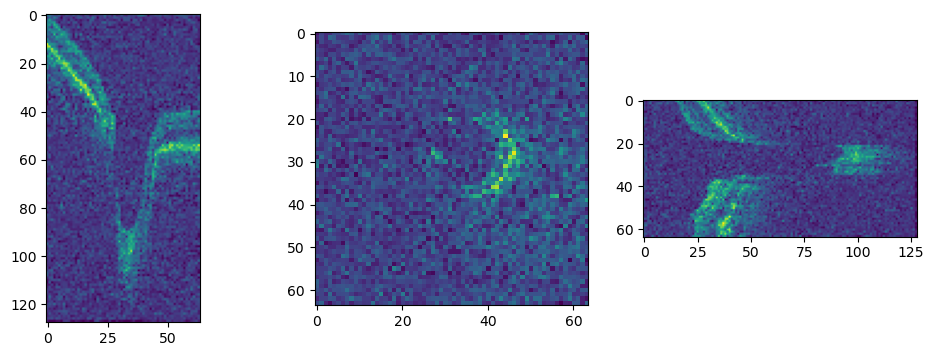

In [68]:
# Plot sample volume slices taken from the middle along various axes of the first volume (index 0)
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(volumes[0,32,:,:])
ax[1].imshow(volumes[0,:,64,:])
ax[2].imshow(volumes[0,:,:,32])

Slices taken orthogonal to the first and last axes of the volume array appear to resemble either transverse (like a common b-scan) or sagittal sections through the retina, while the slices orthogonal to the middle axis appear to be coronal (resembling a circumpapillary scan).  Judging by the asymmetry<sup>&dagger;</sup> of the slice orthogonal to the first axis (far left), this is likely a transverse section.

It can be said that higher indices along the long axes of left and right images represent increasing depth into the retina (i.e., from top to bottom on the left image, from left to right on the right image).  While it seems higher numbers along the short axis of the left image might indicate a medial direction, it is unclear which direction is superior vs inverior in the right image.  Further exploration of axes, including what slices along one dimension correspond to what row/columns in the other slices, can be done during the EDA step.  


 <i><sup>&dagger;</sup>There is naturally more asymmetry along the transverse axis due to the way the optic nerves start out medially in the CNS but diverge laterally to innervate the eyes.</i>

#### SET 2: Axes & Orientations of 2D BSCAN Images

(568, 759, 3)

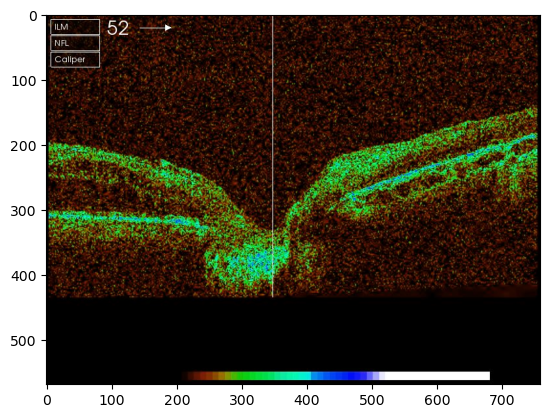

In [69]:
plt.imshow(bscans[0])
# plt.axvline(300,c='red')
# plt.axvline(700,c='red')
bscans[0].shape

These are fairly straightforward, with the first axis simply representing the rows and the second representing the columns of pixels.  Of note, despite being a color image, the actual b-scan part of it seems to be grayscale but inverted - this is because `cv2` reads color images as arrays in BGR format, while `matplotlib.pyplot.imshow()` displays image arrays assuming an RGB format. 

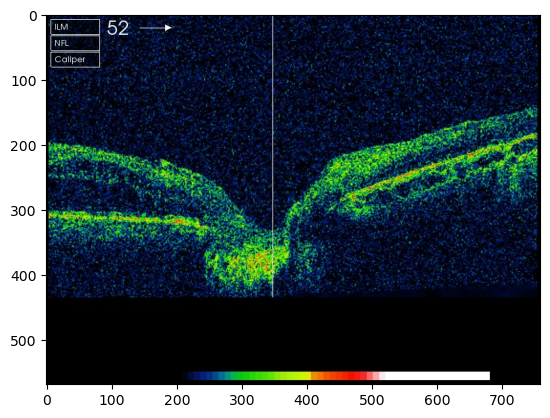

In [70]:
# Preview with conversion to RGB
rgb0 = cv2.cvtColor(bscans[0],cv2.COLOR_BGR2RGB)
plt.imshow(rgb0)

This now looks a lot more similar to the volume slices, which were truly grayscale, although clearly a higher resolution that may need to be downsampled during pre-processing to match the slices.  And to truly match the shape, conversion to grayscale may also be done to each image - for example:

(568, 759)

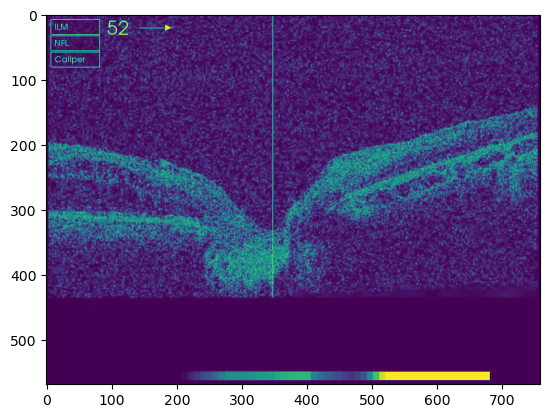

In [71]:
gray0 = cv2.cvtColor(rgb0,cv2.COLOR_BGR2GRAY)
plt.imshow(gray0)
gray0.shape

# 4 | Data Cleaning

## 4.1 | Missing Data 

#### Missing Image Data

While there are essentially no missing data in SET 1, it would seem that there is inconsistency in the types of images in SET 2 (i.e., for patient 12, there is a video for each eye whereas the remaining patients had only 2D images and not enough to string together into video frames; some patients had images with black backgrounds and calipers likely demarcating the bounds of the optic disc or cup in addition to the actual b-scan images, while some simply have such regions shaded in.)  This may not be a problem if only 2D b-scans are considered and perhaps other means are used to crop down to just the optic nerve head (ONH) region - however, given the few numbers of usable images in total, it may be best to simply drop this set and focus on SET 1.  Further consideration of this may be done during EDA along with a final decision to drop or not drop.

##### Missing Tabular Data

The tabular data extracted from filenames & filepaths are not missing any data points / features for the most part, although the `date` column was intentionally added for SET 2 as a column of `NaN` values for the sake of potentionally joining the sets.  That said, this column may be dropped afterwards as it may not be particularly useful for classification. 

In [72]:
voluMetadata.isna().sum()

dx_class      0
patient_id    0
laterality    0
image_type    0
date          0
filepath      0
dtype: int64

In [73]:
bscanMetadata.isna().sum()

dx_class        0
patient_id      0
laterality      0
image_type      0
date          170
filepath        0
dtype: int64

In [74]:
# Combine voluMetadata and bscanMetadata, dropping date column
compositeMetadata = pd.concat([voluMetadata,bscanMetadata]).drop('date',axis=1)

# Add set column to indicate which set number each image is from
compositeMetadata['set'] = compositeMetadata.image_type.apply(lambda x: 1 if x == 'volume' else 2)

# Rearrange columns
compositeMetadata = compositeMetadata["dx_class patient_id laterality image_type set filepath".split(' ')]

print(compositeMetadata.shape) ; compositeMetadata

(1280, 6)


/tmp/ipykernel_3911685/4142371235.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compositeMetadata = pd.concat([voluMetadata,bscanMetadata]).drop('date',axis=1)


,dx_class,patient_id,laterality,image_type,set,filepath
0,glaucoma,001978,OS,volume,1,../datasrc/volumesOCT/POAG-001978-2012-02-08-O...
1,normal,002743,OS,volume,1,../datasrc/volumesOCT/Normal-002743-2009-03-26...
2,glaucoma,001086,OS,volume,1,../datasrc/volumesOCT/POAG-001086-2008-08-04-O...
3,glaucoma,000092,OS,volume,1,../datasrc/volumesOCT/POAG-000092-2010-12-14-O...
4,glaucoma,003223,OD,volume,1,../datasrc/volumesOCT/POAG-003223-2014-01-10-O...
...,...,...,...,...,...,...
404,normal,P_10,OD,b-scan,2,../datasrc/fundus-oct-composite/Healthy/P_10/R...
407,normal,P_10,OS,cup,2,../datasrc/fundus-oct-composite/Healthy/P_10/L...
409,normal,P_10,OS,disc,2,../datasrc/fundus-oct-composite/Healthy/P_10/L...
410,normal,P_10,OS,b-scan,2,../datasrc/fundus-oct-composite/Healthy/P_10/L...


## 4.2 | Duplicates

There were no duplicate images or data points in either set.

# 5 | Saving & Summary

### Saving Metadata

In [75]:
# Save volume metadata DataFrame to CSV
if not os.path.exists('../datasrc/volumeOCT_metadata.csv'):
    voluMetadata.to_csv('../datasrc/volumeOCT_metadata.csv',index=False)

In [76]:
# Save 2D OCT image metadata DataFrame to CSV
if not os.path.exists('../datasrc/bscans2D_metadata.csv'):
    bscanMetadata.to_csv('../datasrc/bscans2D_metadata.csv',index=False)

In [77]:
# Save composite metadata DataFrame to CSV
if not os.path.exists('../datasrc/compositeOCT_metadata.csv'):
    compositeMetadata.to_csv('../datasrc/compositeOCT_metadata.csv',index=False)

### Summary

In this notebook, we:

- Downloaded the OCT volumes
- Downloaded the 2D composite fundus-oct images
- Filtered out non-OCT images from the fundus-oct dataset
- Extracted metadata from the file structure of each dataset into separate DataFrames
- Checked class distribution
- Checked number of actual b-scan images vs. masks/labels
- Checked laterality distribution
- Checked image shape distribution
- Read in the OCT volumes
- Read in 2D OCT image metadata
- Plotted sample volume slices and determined basic dimensions and orientation
- Plotted sample b-scan images and determined basic dimensions and orientation
- Checked for missing data / duplicates
- Performed a preliminary join of the two tabular datasets, leaving further transformation of actual image files for EDA & Pre-processing
- Saved metadata to CSV